# Peak labeling

In [81]:
import logging
import hydra
import torch.nn as  nn 
import erc
from torch.utils.data import DataLoader
from datasets import load_from_disk
import pandas as pd



def dataset2df(dataset, columns = ['emotion']):
    df = pd.DataFrame()
    # for column in columns:
    df[columns] = dataset[columns]
    return df


train_dataset = load_from_disk("/home/hoesungryu/etri-erc/kemdy19-kemdy20_train4_multilabelTrue_rdeuceFalse")
valid_dataset = load_from_disk("/home/hoesungryu/etri-erc/kemdy19-kemdy20_valid4_multilabelTrue_rdeuceFalse")

total_df = pd.concat([pd.DataFrame(train_dataset['emotion']),
                      pd.DataFrame(valid_dataset['emotion'])], axis=0)
total_df.columns = [f'{i}_p' for i in range(1,7+1)]
total_df['vote_emotion'] = list(train_dataset['vote_emotion'].numpy()) + list(valid_dataset['vote_emotion'].numpy()) 

In [82]:
total_df

,1_p,2_p,3_p,4_p,5_p,6_p,7_p,vote_emotion
0,0.9,0.1,0.0,0.0,0.0,0.0,0.0,0
1,0.2,0.7,0.0,0.1,0.0,0.0,0.0,1
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2
3,0.1,0.0,0.9,0.0,0.0,0.0,0.0,2
4,0.2,0.8,0.0,0.0,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...
4925,0.0,0.0,0.0,0.9,0.1,0.0,0.0,3
4926,0.7,0.0,0.0,0.3,0.0,0.0,0.0,0
4927,0.1,0.0,0.0,0.9,0.0,0.0,0.0,3
4928,0.0,0.0,0.1,0.6,0.0,0.0,0.3,3


In [83]:
import numpy as np
take_log = lambda x: -x*np.log(x)


In [84]:
selected_columns = [f'{i}_p' for i in range(1,7+1)]
total_df['entropy'] = total_df[selected_columns].apply(take_log).apply(np.nansum, axis=1)

/home/hoesungryu/.conda/envs/erc/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [85]:
total_df

,1_p,2_p,3_p,4_p,5_p,6_p,7_p,vote_emotion,entropy
0,0.9,0.1,0.0,0.0,0.0,0.0,0.0,0,0.325083
1,0.2,0.7,0.0,0.1,0.0,0.0,0.0,1,0.801819
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2,0.000000
3,0.1,0.0,0.9,0.0,0.0,0.0,0.0,2,0.325083
4,0.2,0.8,0.0,0.0,0.0,0.0,0.0,1,0.500402
...,...,...,...,...,...,...,...,...,...
4925,0.0,0.0,0.0,0.9,0.1,0.0,0.0,3,0.325083
4926,0.7,0.0,0.0,0.3,0.0,0.0,0.0,0,0.610864
4927,0.1,0.0,0.0,0.9,0.0,0.0,0.0,3,0.325083
4928,0.0,0.0,0.1,0.6,0.0,0.0,0.3,3,0.897946


In [138]:
import torch 
import torch.nn.functional as F
def reverse_soft(
        y_soft : torch.Tensor,
        r: int = 0.6
    ) -> torch.Tensor:
    normalize_1 = lambda x: (x-x.min())/(x- x.min()).sum()

    if y_soft.ndim == 1:
        n_label = len(y_soft)
        peak_value = (y_soft - ((r)/n_label)) / (1-r)
        return normalize_1(F.relu(peak_value))
    elif y_soft.ndim == 2:
        n_label = (y_soft >= 0).sum(dim=1)
        peak_value = (y_soft - ((r)/n_label.unsqueeze(1))) / (1-r)
        peak_value = F.relu(peak_value)
        
        numerator = peak_value - peak_value.min(axis=1).values.unsqueeze(1)
        denominator = numerator.sum(axis=1).unsqueeze(1)
        
        return numerator /denominator


In [139]:
peak_df = pd.DataFrame(reverse_soft(torch.from_numpy(total_df[selected_columns].values)).numpy())
peak_df['vote_emotion'] = total_df['vote_emotion'].values
peak_df

,0,1,2,3,4,5,6,vote_emotion
0,0.982759,0.017241,0.000000,0.000000,0.000000,0.0,0.000000,0
1,0.153846,0.826923,0.000000,0.019231,0.000000,0.0,0.000000,1
2,0.000000,0.000000,1.000000,0.000000,0.000000,0.0,0.000000,2
3,0.017241,0.000000,0.982759,0.000000,0.000000,0.0,0.000000,2
4,0.137931,0.862069,0.000000,0.000000,0.000000,0.0,0.000000,1
...,...,...,...,...,...,...,...,...
23453,0.000000,0.000000,0.000000,0.982759,0.017241,0.0,0.000000,3
23454,0.741379,0.000000,0.000000,0.258621,0.000000,0.0,0.000000,0
23455,0.017241,0.000000,0.000000,0.982759,0.000000,0.0,0.000000,3
23456,0.000000,0.000000,0.019231,0.692308,0.000000,0.0,0.288462,3


In [140]:
peak_df['entropy'] = peak_df.drop(["vote_emotion"],axis=1).apply(take_log).apply(np.nansum, axis=1)

/home/hoesungryu/.conda/envs/erc/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [141]:
peak_df

,0,1,2,3,4,5,6,vote_emotion,entropy
0,0.982759,0.017241,0.000000,0.000000,0.000000,0.0,0.000000,0,0.087099
1,0.153846,0.826923,0.000000,0.019231,0.000000,0.0,0.000000,1,0.521106
2,0.000000,0.000000,1.000000,0.000000,0.000000,0.0,0.000000,2,0.000000
3,0.017241,0.000000,0.982759,0.000000,0.000000,0.0,0.000000,2,0.087099
4,0.137931,0.862069,0.000000,0.000000,0.000000,0.0,0.000000,1,0.401190
...,...,...,...,...,...,...,...,...,...
23453,0.000000,0.000000,0.000000,0.982759,0.017241,0.0,0.000000,3,0.087099
23454,0.741379,0.000000,0.000000,0.258621,0.000000,0.0,0.000000,0,0.571609
23455,0.017241,0.000000,0.000000,0.982759,0.000000,0.0,0.000000,3,0.087099
23456,0.000000,0.000000,0.019231,0.692308,0.000000,0.0,0.288462,3,0.689178


In [143]:
peak_df['entropy'].describe()

count    23458.000000
mean         0.394636
std          0.334771
min          0.000000
25%          0.087099
50%          0.401190
75%          0.663725
max          1.609438
Name: entropy, dtype: float64

<Axes: xlabel='vote_emotion'>

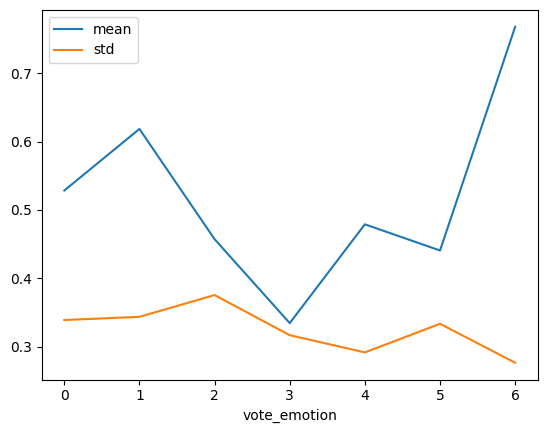

In [142]:
pd.pivot_table(data=peak_df, 
               values = "entropy", 
               columns = "vote_emotion",
               aggfunc={"mean","std"}).T.plot()

<Axes: xlabel='vote_emotion'>

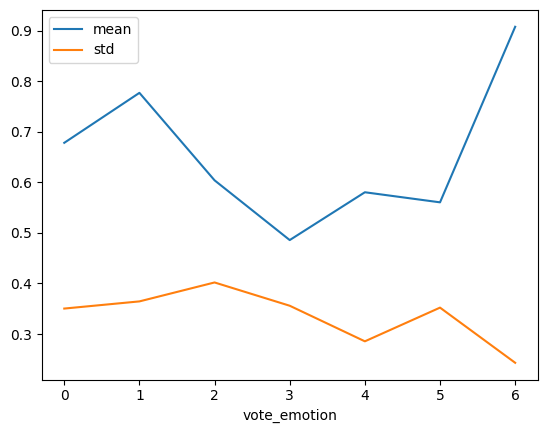

In [75]:
idx2emotion = {
    0: 'surprise',
    1: 'fear',
    2: 'angry',
    3: 'neutral',
    4: 'happy',
    5: 'sad',
    6: 'disgust'
}

pd.pivot_table(data=total_df, 
               values = "entropy", 
               columns = "vote_emotion",
               aggfunc={"mean","std"}).T.plot()

<Axes: xlabel='vote_emotion'>

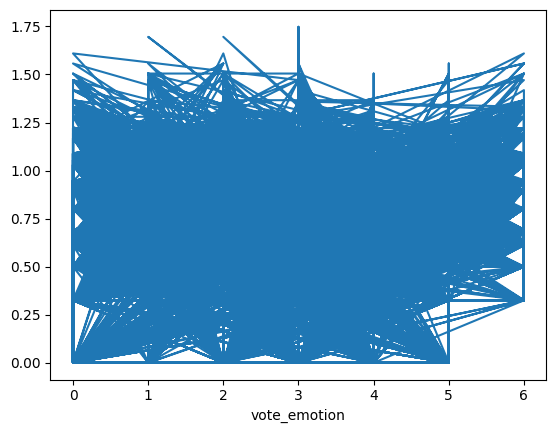

In [67]:
total_df.set_index("vote_emotion")['entropy'].plot()

<Axes: ylabel='Frequency'>

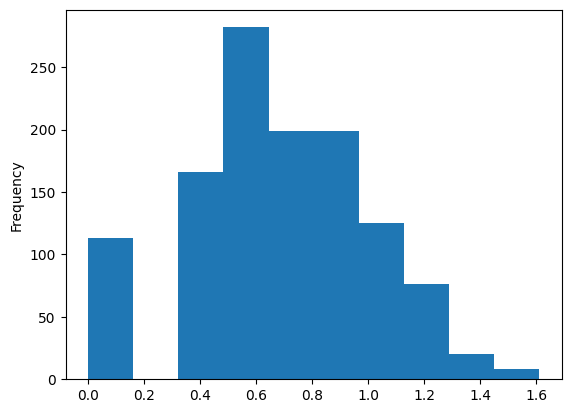

In [63]:
total_df[total_df['vote_emotion'] == 0]["entropy"].plot.hist()

<Axes: ylabel='Frequency'>

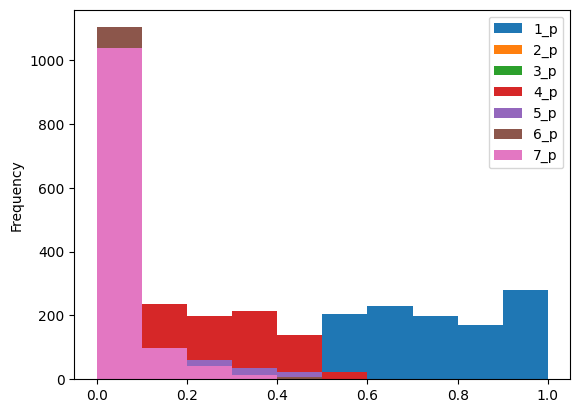

In [28]:
train_dataset['vote_emotion'].unsqueeze(dim=1)

tensor([[0],
        [1],
        [2],
        ...,
        [3],
        [3],
        [3]])

In [24]:
valid_dataset['vote_emotion']

tensor([3, 3, 6,  ..., 3, 3, 0])

In [13]:
total_df

,1_p,2_p,3_p,4_p,5_p,6_p,7_p
0,0.9,0.1,0.0,0.0,0.0,0.0,0.0
1,0.2,0.7,0.0,0.1,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.1,0.0,0.9,0.0,0.0,0.0,0.0
4,0.2,0.8,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
4925,0.0,0.0,0.0,0.9,0.1,0.0,0.0
4926,0.7,0.0,0.0,0.3,0.0,0.0,0.0
4927,0.1,0.0,0.0,0.9,0.0,0.0,0.0
4928,0.0,0.0,0.1,0.6,0.0,0.0,0.3


<Axes: >

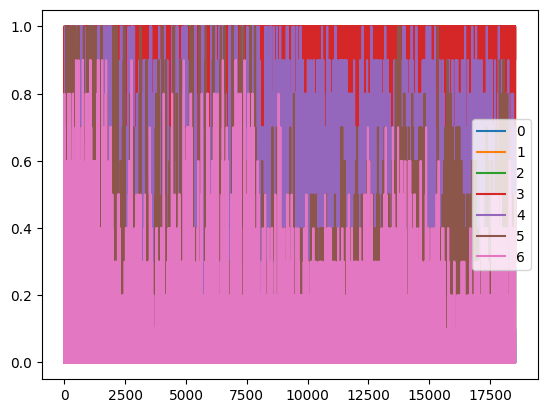

In [8]:
total_df.plot(kind=)

In [ ]:
train_dataset['emotion']

In [ ]:
train_dataset[0]

## MLP-mixer _convert 


In [ ]:
import torch
import numpy as np
from erc.model import MLPMixer

audio_output = torch.ones([3, 1024]) # Batch, Seq
text_output = torch.ones([3, 768]) # Batch, Seq


# Performs a batch matrix-matrix product of matrices stored in input and mat2.
matmul_output = torch.bmm(audio_output.unsqueeze_(2), text_output.unsqueeze_(1))
print(matmul_output.unsqueeze_(1).shape) # Batch, Color, Width, Hight


model = MLPMixer(
    image_size = (1024, 768),
    channels = 1,
    patch_size = 16,
    dim = 512,
    depth = 12,
    num_classes = 7
)
pred = model(matmul_output) 
print(pred.shape)



## AI-Hub dataset


In [ ]:
import os 
from glob import glob

def get_hub_txt(self, txt: str, encoding: str = None)-> Tuple[torch.Tensor, torch.Tensor]:
    if self.tokenizer:
        result: dict = self.tokenizer(text=txt,
                                    padding="max_length",
                                    truncation="only_first",
                                    max_length=self.max_length_txt,
                                    return_attention_mask=True,
                                    return_tensors="pt")
        input_ids = result["input_ids"].squeeze()
        mask = result["attention_mask"].squeeze()
        return input_ids, mask
    else:
        return txt, None
    
class AIHubDialog():
    # PRETRAINED_DATA_PATH = '/home/hoesungryu/workspace/AI-Hub_emotion_dialog'
    def __init__(self, PRETRAINED_DATA_PATH):
        self.txt_folder = sorted(glob(os.path.join(PRETRAINED_DATA_PATH,'annotation')+'/*.csv'))
        self.wav_folder = sorted(glob(os.path.join(PRETRAINED_DATA_PATH,'wav')+'/*.wav'))

    def __len__(self):
        assert len(glob(self.wav_folder)) == len(glob(self.txt_folder))
        return len(glob(self.wav_folder)) 
    
    def __getitem__(self, idx:int):
        data = {}
        txt, _, emotion = pd.read_csv(self.txt_folder[idx]).iloc[0].values
    
        # Txt File
        txt, txt_mask = self.get_hub_txt(txt_path=txt, encoding=self.TEXT_ENCODING)
        data["txt"] = txt
        data["txt_mask"] = txt_mask
    
        # emotion 
        data["emotion"] = self.get_emo(emotion)

        sampling_rate, wav, wav_mask = self.get_wav(wav_path=self.wav_folder[idx])
        data["sampling_rate"] = sampling_rate
        data["wav"] = wav
        data["wav_mask"] = wav_mask

        return data
    
import random 
random.seed(42)

@staticmethod
def sampling_with_ratio(total_len : int, train_ratio = 0.8):
    total_len = wav_folder 
    total_idx = [i for i in range(total_len)]
    train_num = int(total_len * train_ratio)

    train_idx = random.sample(total_idx, train_num)
    valid_idx = list(set(total_idx) - set(train_idx))

    return train_idx, valid_idx

@staticmethod
def get_multiple_elements_in_list(in_list, in_indices):
    """리스트에서 복수인덱스 값을 가져온다"""
    return [in_list[i] for i in in_indices]

## Weighted Cross-entropy


In [ ]:
# Get Centroid ... 
from collections import defaultdict

emotion_va_dic = defaultdict(dict)

emotion_va_dic[emotion+'_arousal'] = arousal
emotion_va_dic[emotion+'_valence'] = valence



In [ ]:
for emotion_idx in range(0,7):
    

In [ ]:
import logging
import hydra

import erc
from torch.utils.data import DataLoader
from datasets import load_from_disk

train_dataset = load_from_disk("/home/hoesungryu/etri-erc/kemdy19-kemdy20_train4")
valid_dataset = load_from_disk("/home/hoesungryu/etri-erc/kemdy19-kemdy20_valid4")


train_dataloadaer = DataLoader(train_dataset, batch_size=2)
sample = next(iter(train_dataloadaer))

In [ ]:
train_dataset[train_dataset['emotion'] ==3]

In [ ]:
train_dataset['emotion'].numpy()

In [ ]:

class_count = Counter(train_dataset['emotion'].detach().cpu().numpy())
class_count

In [ ]:
nSamples = class_count.values()
nSamples

In [ ]:
import torch
# nSamples = [887, 6130, 480, 317, 972, 101, 128]
normedWeights = torch.FloatTensor([1 - (x / sum(nSamples)) for x in nSamples])
# normedWeights = torch.FloatTensor(normedWeights)

loss = nn.CrossEntropyLoss(normedWeights)


In [ ]:
import logging
import hydra
import torch.nn as  nn 
import erc
from torch.utils.data import DataLoader
from datasets import load_from_disk

train_dataset = load_from_disk("/home/hoesungryu/etri-erc/kemdy19-kemdy20_train4")
valid_dataset = load_from_disk("/home/hoesungryu/etri-erc/kemdy19-kemdy20_valid4")


# from collections import Counter

# def get_classweights(traindataset)-> torch.FloatTensor:
#     class_count = Counter(traindataset['emotion'].numpy())
#     nSamples = class_count.values()
#     normedWeights = [1 - (x / sum(nSamples)) for x in nSamples]
#     return torch.FloatTensor(normedWeights)

# train_normedWeight = get_classweights(train_dataset)
# valid_normedWeight = get_classweights(valid_dataset)


In [ ]:
# loss = nn.CrossEntropyLoss(train_normedWeight)
train_normedWeight


## Get Ground Truth emotion in Multi-label-class

```python 

logits = self.mlp_mixer(matmul_output) # (B, num_labels)

# calcuate the loss fct
cls_logits = logits[:, :-2]
cls_labels = labels["emotion"]
if cls_labels.ndim == 1:
    # Single label case
    cls_loss = self.criterions["cls"](cls_logits, cls_labels.long())
elif cls_labels.ndim == 2:
    # Multi label case
    cls_loss = self.criterions["cls"](cls_logits, cls_labels.float())
    cls_labels = labels["emotion_deuce"] # trainer 도 바꿔줘야됨 ... 

reg_logits = logits[:, -2:]
reg_loss = self.criterions["reg"](reg_logits, labels["regress"].float())

total_loss = cls_loss * self.cls_coef + reg_loss * self.reg_coef
return {
    "loss": total_loss,
    "cls_loss": cls_loss.detach().cpu(),
    "reg_loss": reg_loss.detach().cpu(),
    "emotion": cls_labels.detach(),
    "regress": labels["regress"].detach(),
    "cls_pred": cls_logits.detach(),
    "reg_pred": reg_logits.detach(),
}

```

In [ ]:
# get centroid 
import logging
import hydra
import pandas as pd


import torch.nn as  nn 

from torch.utils.data import DataLoader
from datasets import load_from_disk

import erc

train_dataset = load_from_disk("/home/hoesungryu/etri-erc/kemdy19-kemdy20_train4")
valid_dataset = load_from_disk("/home/hoesungryu/etri-erc/kemdy19-kemdy20_valid4")


def dataset2df(dataset, columns = ['emotion','valence','arousal']):
    df = pd.DataFrame()
    for column in columns:
        df[column] = dataset[column]
    return df

train_df = dataset2df(train_dataset)
valid_df = dataset2df(valid_dataset)

total_df = pd.concat([train_df,valid_df], axis=0)
display(total_df)
# Get Centroid ... 
from collections import defaultdict

emotion_va_dict = defaultdict(dict)

for emotion_idx in range(0,7):
    valence = total_df[total_df['emotion']==emotion_idx]['valence'].mean()
    arousal = total_df[total_df['emotion']==emotion_idx]['arousal'].mean()
    # print()
    emotion_va_dict[f'{emotion_idx}_centroid'] = (valence, arousal)
emotion_va_dict

In [ ]:
# get centroid 
import logging
import hydra
import pandas as pd


import torch.nn as  nn 

from torch.utils.data import DataLoader
from datasets import load_from_disk

import erc

train_dataset = load_from_disk("/home/hoesungryu/etri-erc/kemdy19_train4")
valid_dataset = load_from_disk("/home/hoesungryu/etri-erc/kemdy19_valid4")


def dataset2df(dataset, columns = ['emotion','valence','arousal']):
    df = pd.DataFrame()
    for column in columns:
        df[column] = dataset[column]
    return df

train_df = dataset2df(train_dataset)
valid_df = dataset2df(valid_dataset)

total_df = pd.concat([train_df,valid_df], axis=0)
display(total_df)
# Get Centroid ... 
from collections import defaultdict

emotion_va_dict = defaultdict(dict)

for emotion_idx in range(0,7):
    valence = total_df[total_df['emotion']==emotion_idx]['valence'].mean()
    arousal = total_df[total_df['emotion']==emotion_idx]['arousal'].mean()
    # print()
    emotion_va_dict[f'{emotion_idx}_centroid'] = (valence, arousal)
emotion_va_dict

In [ ]:
# get centroid 
import logging
import hydra
import pandas as pd


import torch.nn as  nn 

from torch.utils.data import DataLoader
from datasets import load_from_disk

import erc

train_dataset = load_from_disk("/home/hoesungryu/etri-erc/kemdy20_train4")
valid_dataset = load_from_disk("/home/hoesungryu/etri-erc/kemdy20_valid4")


def dataset2df(dataset, columns = ['emotion','valence','arousal']):
    df = pd.DataFrame()
    for column in columns:
        df[column] = dataset[column]
    return df

train_df = dataset2df(train_dataset)
valid_df = dataset2df(valid_dataset)

total_df = pd.concat([train_df,valid_df], axis=0)
display(total_df)
# Get Centroid ... 
from collections import defaultdict

emotion_va_dict = defaultdict(dict)

for emotion_idx in range(0,7):
    valence = total_df[total_df['emotion']==emotion_idx]['valence'].mean()
    arousal = total_df[total_df['emotion']==emotion_idx]['arousal'].mean()
    # print()
    emotion_va_dict[f'{emotion_idx}_centroid'] = (valence, arousal)
emotion_va_dict

In [ ]:
# transformation 

import erc

validation_fold: int = 4
PRETRAINED_DATA_PATH: str = "./aihub"
mode: str = "train"
wav_processor: str = "kresnik/wav2vec2-large-xlsr-korean"
sampling_rate: int = 16_000
wav_max_length: int = 112_000 # 16_000 * 7, 7secs duration
txt_processor: str = "klue/bert-base"
txt_max_length: int = 64
multilabel: bool = True
load_from_cache_file: bool = True
num_proc: int = 8
batched: bool = True
batch_size: int = 1000 # Not a torch batch_size
writer_batch_size: int = 1000
num_data: int = None
preprocess: bool = True


ds_kwargs = dict(
    # Note for hard-coded kwargs
    # generate_csv=False,
    return_bio=False,
    tokenizer_name=None,
    max_length_wav=wav_max_length,
    max_length_txt=txt_max_length,
    multilabel=multilabel,
    validation_fold=validation_fold,
    mode=mode,
    num_data=num_data,
    # PRETRAINED_DATA_PATH=PRETRAINED_DATA_PATH,
)

ds = erc.datasets.KEMDDataset(**ds_kwargs)

In [ ]:
# from erc.constants import emotion_va_19_dict, emotion_va_20_dict, emotion_va_19_20_dict

# # paths from HF_KEMD __init__ paths

# if paths =='kemdy19':
#     emotion_va_dict = emotion_va_19_dict
# elif paths == 'kemdy20':
#     emotion_va_dict = emotion_va_20_dict
# elif paths == 'kemdy19-kemdy20':
#     emotion_va_dict = emotion_va_19_20_dict

# def find_deuce_label(regress : torch.tensor, deuce_mask : torch.tensor) -> torch.tensor:
#     '''
#     Summary:
#         동률인 것 중 거리가 가장 작은 것을 사용하여 라벨을 확정한다. 
#     Input
#        regress = torch.tensor([valence, arousal])
#        deuce_maks = tensor([False,  True, False,  True, False, False, False])
#     Output
#         return minmum index in deuce_mask
#     '''
    
#     deuce_mask = deuce_mask.nonzero().squeeze().numpy()
#     total_dist = []
#     for index in deuce_mask:
#         item = emotion_va_dict[f'{index}_centroid']
#         tmp_va_tensor = torch.tensor(item)
        
#         tmp_dist = torch.norm(regress-tmp_va_tensor, 2, dim=0)
#         total_dist.append(tmp_dist)

#     total_dist = torch.stack(total_dist, -1) # reshape -1 
#     return torch.tensor(deuce_mask[total_dist.argmin()]) # select minumum value index



# for batch in ds:
#     tmp_emotion = torch.tensor(batch['emotion'].astype(float))
#     deuce_mask = (tmp_emotion == tmp_emotion.max())
#     if len(tmp_emotion[deuce_mask]) > 1:
#         regress = torch.stack([batch['valence'], batch["arousal"]])
#         gt_emotion = find_deuce_label(regress, deuce_mask)

#     else:
#         gt_emotion = tmp_emotion.argmax()


In [ ]:
torch.ones(7,).argmax()

In [ ]:
torch.tensor([0.0000, 0.4000, 0.2000, 0.4000, 0.0000, 0.0000, 0.0000]).argmax()

In [ ]:
deuce_mask == True
for index in deuce_mask.nonzero().squeeze().numpy():
    print(index)

## Training model using PEFT 


In [ ]:
# !pip install -q git+https://github.com/huggingface/peft.git

In [ ]:
from peft import get_peft_model, LoraConfig, TaskType
peft_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    target_modules=["q_proj", "v_proj"],
    inference_mode=False, r=8, lora_alpha=32, lora_dropout=0.1
)

In [ ]:
from transformers import Wav2Vec2ForSequenceClassification, BertForSequenceClassification, AutoModelForSequenceClassification

wav_name = "kresnik/wav2vec2-large-xlsr-korean"
# wav_name = "roberta-large"
wav_model_ = Wav2Vec2ForSequenceClassification.from_pretrained(wav_name).wav2vec2
# wav_model = AutoModelForSequenceClassification.from_pretrained(wav_name)
wav_model_ = get_peft_model(wav_model_, peft_config)
# wav_model = wav_model_.wav2vec2


In [ ]:
wav_model = get_peft_model(wav_model, peft_config)

In [ ]:
import torch
sampel_wav = torch.randn([3,112000])

wav_model_(sampel_wav)

In [ ]:
from transformers import Wav2Vec2ForSequenceClassification, BertForSequenceClassification


from peft import get_peft_model, LoraConfig, TaskType
peft_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    # target_modules=["q_proj", "v_proj"],
    inference_mode=False, 
    r=8, 
    lora_alpha=32,
    lora_dropout=0.1
)


txt_model = BertForSequenceClassification.from_pretrained("klue/bert-base")
model = get_peft_model(txt_model, peft_config)

In [ ]:
sampel_wav = torch.randn([3,112000])
model(sampel_wav)

In [ ]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

In [ ]:
print_trainable_parameters(model)

In [ ]:
print_trainable_parameters(model)

In [ ]:
dir(TaskType)

In [ ]:
emotion_va_dict = {
    '0_centroid': (2.7013428, 3.6017902),
    '1_centroid': (1.8056872, 3.5810425),
    '2_centroid': (1.8337096, 3.7831194),
    '3_centroid': (2.989782, 3.1387265),
    '4_centroid': (4.093699, 3.7420354),
    '5_centroid': (1.9814088, 2.6549654),
    '6_centroid': (2.2050884, 3.1471236)}

In [ ]:
emotion_va_dict[1]

In [ ]:
import torch
cls_logits   = torch.randn([3, 9]) # Batch, Seq
cls_labels  = torch.ones([3, 9]) # Batch, Seq

emotion = torch.ones(1)
gt_arousal = torch.tensor([[3.],[2.0],[3.1]])# labels["arousal"]
gt_valence = torch.tensor([[3.],[2.0],[3.1]])# labels["valence"]

print('pred:\n',cls_logits)
print('gt:\n',cls_labels)

In [ ]:
elif cls_labels.ndim == 2:
    cls_loss = self.criterions["cls"](cls_logits, cls_labels.float())

    print(cls_labels.max(dim=1).values)
    if len(cls_labels.max(dim=1).values) > 1:
        # Compare distance with Centroid    
    else:
        # 
        cls_labels = cls_labels.argmax(dim=1)

    
print(len(cls_labels.max(dim=1).values))

In [ ]:
cls_labels  = torch.ones([3, 9]) # Batch, Seq
if len(cls_labels.max(dim=1).values) > 1:
    

In [ ]:
cls_labels  = torch.randn([3, 9]) # Batch, Seq
cls_labels.argmax(dim=1)

In [ ]:
gt_emotion

In [ ]:
tmp_emotion

In [ ]:
regress

In [ ]:
tmp_emotion

In [ ]:
regress

In [ ]:
tmp_emotion = torch.tensor([3,1,3,1,0,2,0])
emotion_max = tmp_emotion.max()

# max 값이 두개 이상이면 그때 거리로 구한다. 
if len(tmp_emotion[tmp_emotion == tmp_emotion.max()]) > 1:
    



In [ ]:
ds_kwargs = dict(
    # Note for hard-coded kwargs
    # generate_csv=False,
    return_bio=False,
    tokenizer_name=None,
    max_length_wav=wav_max_length,
    max_length_txt=txt_max_length,
    multilabel=multilabel,
    validation_fold=validation_fold,
    mode="valid",
    num_data=num_data,
    # PRETRAINED_DATA_PATH=PRETRAINED_DATA_PATH,
)

ds = erc.datasets.KEMDDataset(**ds_kwargs)

In [ ]:
for batch in ds:
    tmp_emotion = torch.tensor(batch['emotion'].astype(float))
    if len(tmp_emotion.unique()) > 1:
        continue
        gt_emotion = tmp_emotion.argmax()
    else:
        regress = torch.stack([batch['valence'], batch["arousal"]])
        gt_emotion = find_duece_label(regress)
        break

In [ ]:
gt_emotion

In [ ]:
if len(tmp_emotion.unique()) > 1:
    gt_emotion = tmp_emotion.argmax()
else:
    gt_emotion = find_duece_label(tmp_emotion)

In [ ]:
tmp_emotion.shape

In [ ]:
print(tmp_emotion.unique())
print(len(tmp_emotion.unique()))

In [ ]:
tmp_emotion.max()

In [ ]:
cls_labels  = torch.ones(7,) # Batch, Seq
cls_labels

In [ ]:
cls_labels.unique()

In [ ]:
    
print(len(cls_labels.max(dim=1).values))

In [ ]:
def check

In [ ]:
for batch in ds:
    regress = torch.stack([batch['valence'], batch["arousal"]])
    print(regress)
    break

In [ ]:
total_dist

In [ ]:
total_dist = torch.stack(total_dist, -1)

In [ ]:
total_dist

In [ ]:
outx = []
for i in range(5):
    tmp = net(x) # this will return a 10x10 tensor
    outx.append(tmp)

outx = torch.stack(outx, 2)

In [ ]:
regress = torch.tensor([[ds[0]['valence'], ds[0]['arousal']],
                       [ds[1]['valence'], ds[1]['arousal']],
                       [ds[2]['valence'], ds[2]['arousal']],
                    ])

In [ ]:
regress

In [ ]:
regress.shape

In [ ]:
torch.norm(regress-regress, 2, dim=1)

In [ ]:
tmp_va_tensor = torch.tensor((1.9814088, 2.6549654))
batch_size = 3
tmp_va_tensor.repeat(batch_size,1)

In [ ]:
batch_size, *_ = regress.shape

total_dist = []
total_dist = torch.tensor()
for key, item in emotion_va_dict.items():
    tmp_va_tensor = torch.tensor(item).repeat(batch_size,1)
    
    tmp_dist = torch.norm(regress-tmp_va_tensor, 2, dim=1)
    total_dist.append(tmp_dist)
    
    


In [ ]:
total_dist


In [ ]:
torch.norm(regress, tmp_va_tensor)

In [ ]:
labels = {}
for batch in ds:
    torch.stack([batch["valence"], batch["arousal"]], dim=1).float()
    break

## Load weight with Torchlightning


In [ ]:
from erc.trainer import ERCModule
from erc.model import MLP_Mixer

WEIGHTS_PATH = '/home/hoesungryu/etri-erc/weights_AI_HUB/26908-valid_acc0.994.ckpt'

erc.trainer.train(config)
model = ERCModule(MLP_Mixer).load_from_checkpoint(WEIGHTS_PATH)
print(model.learning_rate)

## Change loss function

```python
erc.optims.multi_class_focal_loss import FocalLoss
```

